### (0) Simulate with the Diffusion and No Jumps

In [1]:
using DiffEqJump, StochasticDiffEq, DiffEqCallbacks
using StatsBase, Parameters, Plots, Distributions

In [2]:
# functional parameters 
function drift(du,u,p,t) # constant drift
      du .= p.μ
end
function volatility(du,u,p,t) # constant shock exposure
      du .= p.σ
end
function rate_index(u, p, t, index)
   u_max = maximum(u)
   u_min = minimum(u)
   return p.ρ_max* ((u[index] - u_max)^2 / (u_max - u_min))
end
affect_index!(integrator, index) = (integrator.u[index] =
    max(integrator.u[index], integrator.u[rand(1:integrator.p.N)]))

# main params bundle
params = @with_kw (
    μ = 0.01, # mean
    σ = 0.1, # drift
    N = 10, # num particles
    β = 0.2, # rate parameter
    t = 0.:0.01:10., # time steps to save
    moments = Array{Array{Float64, 1}, 1}(), # container for moments
    α = 2.0, # shape parameter for the initial condition distribution
    iv_dist = Exponential(1/α), # updates based on supplied α
    trajectories = 2, # number of members for ensemble methods 
    jump_algorithm = SRIW1(), # jump diffeq algorithm
    drift = drift, 
    rate_index = rate_index,
    volatility = volatility,
    affect_index! = affect_index!,
    ρ_max = 2.0,
    rate = Nothing)

#3 (generic function with 2 methods)

In [3]:
struct AffectIndex{F1, F2}
    affect_index!::F1
    index::F2
end
function (p::AffectIndex)(integrator)
    return p.affect_index!(integrator, p.index)
end
struct RateIndex{F1, F2}
    rate_index::F1
    index::F2
end
function (q::RateIndex)(u, p, t)
    return q.rate_index(u, p, t, q.index)
end

function generate_jump_prob(p)
    x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, x_iv, (0.0, p.t[end]), p)
#   ==========    DISABLING JUMPS    ==========
#   jumps = [VariableRateJump(RateIndex(p.rate_index, i), AffectIndex(p.affect_index!, i)) for i in 1:p.N];
#   jump_prob = JumpProblem(sde_prob, Direct(), JumpSet((jumps),(),nothing,nothing))
    return sde_prob
end

function generate_ensemble_prob(p)
    prob = generate_jump_prob(p)
    function write_moments(sol, i)
        newsol = DiffEqBase.build_solution(sol.prob, sol.alg, sol.prob.p.t, sol.prob.p.moments)
        return newsol, false
    end
    function calculate_moments(u, t, integrator) 
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), maximum(u), g]
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    ensemble_prob = EnsembleProblem(prob, output_func = write_moments)    
    return ensemble_prob, cb
end
    
p = params();

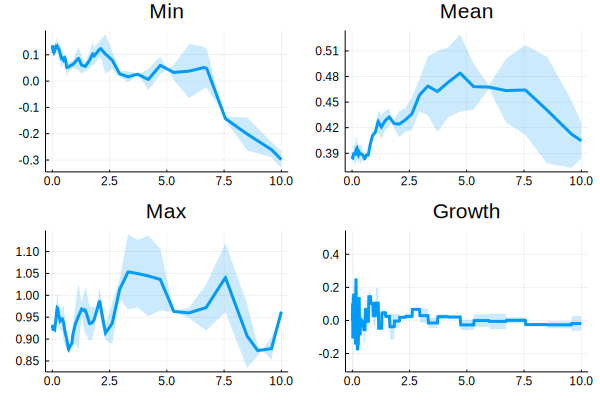

In [4]:
ensemble_prob, cb = generate_ensemble_prob(p)
sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)

p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Max")
p4 = plot(summ, idxs = [4], title = "Growth")

plot(p1, p2, p3, p4)

This is largely what we saw before, when we had accidentally passed in the code for the `sde_prob` to the ensemble solver instead of the `jump_prob`. 

So, this passes a sanity check for me. 

### (1) Constant Rate Jumps, but One Per Particle

This is coming from the `src/single_jump_instead_of_many.jl`.

In [5]:
# new boilerplate
struct AffectIndex{F1, F2}
  affect_index!::F1
  index::F2
end

function (p::AffectIndex)(integrator)
    return p.affect_index!(integrator, p.index)
end

function affect!(integrator)
  n = rand(1:integrator.p.N)
  n2 = rand(1:integrator.p.N)
  integrator.u[n] = max(integrator.u[n], integrator.u[n2])
end

function drift(du,u,p,t)
  du .= p.μ
end

function volatility(du,u,p,t)
  du .= p.σ
end

rate(u,p,t) = 0.2 # RATE FROM POOYA
affect_index!(integrator, index) = (integrator.u[index] =
                                    max(integrator.u[index], integrator.u[rand(1:integrator.p.N)]))

affect_index! (generic function with 1 method)

In [6]:
# New problem generation 

function generate_jump_prob(p)
    x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, x_iv, (0.0, p.t[end]), p)
#   ==========    CONSTANT JUMP CODE    ==========
    jumps = [ConstantRateJump(p.rate, AffectIndex(p.affect_index!, i)) for i in 1:p.N]
    jump_prob = JumpProblem(prob,Direct(),JumpSet((), jumps, nothing, nothing))
    return jump_prob
end

function generate_ensemble_prob(p)
    prob = generate_jump_prob(p)
    function write_moments(sol, i)
        newsol = DiffEqBase.build_solution(sol.prob, sol.alg, sol.prob.p.t, sol.prob.p.moments)
        return newsol, false
    end
    function calculate_moments(u, t, integrator) 
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), maximum(u), g]
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    ensemble_prob = EnsembleProblem(prob, output_func = write_moments)    
    return ensemble_prob, cb
end

generate_ensemble_prob (generic function with 1 method)

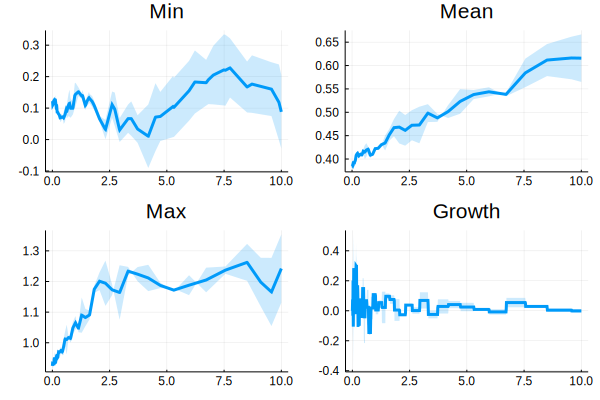

In [7]:
# Run and solve 
p = params(rate = rate, affect_index! = affect_index!, drift = drift, volatility = volatility)
sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)

p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Max")
p4 = plot(summ, idxs = [4], title = "Growth")
plot(p1, p2, p3, p4)

### (2) Variable Rate Code, but Constant # Per Agent

In [8]:
# Refresh Boilerplate 
function drift(du,u,p,t) # constant drift
      du .= p.μ
end

function volatility(du,u,p,t) # constant shock exposure
      du .= p.σ
end

function rate_index(u, p, t, index)
   u_max = maximum(u)
   u_min = minimum(u)
   return p.ρ_max* ((u[index] - u_max)^2 / (u_max - u_min))
end

affect_index!(integrator, index) = (integrator.u[index] =
    max(integrator.u[index], integrator.u[rand(1:integrator.p.N)]))

struct AffectIndex{F1, F2}
    affect_index!::F1
    index::F2
end

function (p::AffectIndex)(integrator)
    return p.affect_index!(integrator, p.index)
end

struct RateIndex{F1, F2}
    rate_index::F1
    index::F2
end

function (q::RateIndex)(u, p, t)
    return q.rate_index(u, p, t, q.index)
end

function generate_jump_prob(p)
    x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, x_iv, (0.0, p.t[end]), p)
    jumps = [VariableRateJump(RateIndex(p.rate_index, i), AffectIndex(p.affect_index!, i)) for i in 1:p.N];
    jump_prob = JumpProblem(sde_prob, Direct(), JumpSet((jumps),(),nothing,nothing))
    return jump_prob
end

function generate_ensemble_prob(p)
    prob = generate_jump_prob(p)
    function write_moments(sol, i)
        newsol = DiffEqBase.build_solution(sol.prob, sol.alg, sol.prob.p.t, sol.prob.p.moments)
        return newsol, false
    end
    function calculate_moments(u, t, integrator) 
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), maximum(u), g]
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    ensemble_prob = EnsembleProblem(prob, output_func = write_moments)    
    return ensemble_prob, cb
end

generate_ensemble_prob (generic function with 1 method)

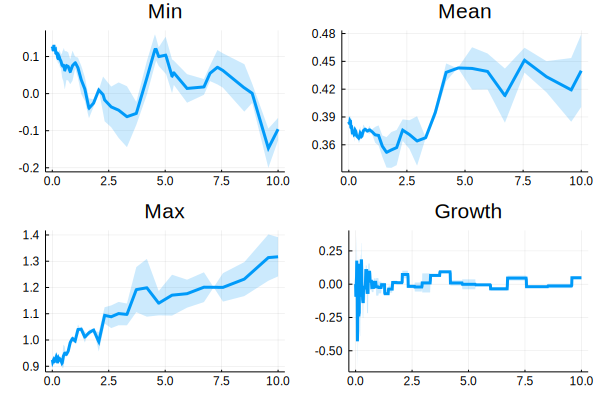

In [9]:
p = params(rate_index = rate_index, affect_index! = affect_index!, drift = drift, volatility = volatility)
sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)

p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Max")
p4 = plot(summ, idxs = [4], title = "Growth")
plot(p1, p2, p3, p4)

### (3) Variable Rate Jumps, Useless Affect

In [10]:
# Refresh Boilerplate 
function drift(du,u,p,t) # constant drift
      du .= p.μ
end

function volatility(du,u,p,t) # constant shock exposure
      du .= p.σ
end

function rate_index(u, p, t, index)
   u_max = maximum(u)
   u_min = minimum(u)
   return p.ρ_max* ((u[index] - u_max)^2 / (u_max - u_min))
end

# ======== USELESS AFFECT ========
affect_index!(integrator, index) = nothing 

struct AffectIndex{F1, F2}
    affect_index!::F1
    index::F2
end

function (p::AffectIndex)(integrator)
    return p.affect_index!(integrator, p.index)
end

struct RateIndex{F1, F2}
    rate_index::F1
    index::F2
end

function (q::RateIndex)(u, p, t)
    return q.rate_index(u, p, t, q.index)
end

function generate_jump_prob(p)
    x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, x_iv, (0.0, p.t[end]), p)
    jumps = [VariableRateJump(RateIndex(p.rate_index, i), AffectIndex(p.affect_index!, i)) for i in 1:p.N];
    jump_prob = JumpProblem(sde_prob, Direct(), JumpSet((jumps),(),nothing,nothing))
    return jump_prob
end

function generate_ensemble_prob(p)
    prob = generate_jump_prob(p)
    function write_moments(sol, i)
        newsol = DiffEqBase.build_solution(sol.prob, sol.alg, sol.prob.p.t, sol.prob.p.moments)
        return newsol, false
    end
    function calculate_moments(u, t, integrator) 
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), maximum(u), g]
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    ensemble_prob = EnsembleProblem(prob, output_func = write_moments)    
    return ensemble_prob, cb
end

generate_ensemble_prob (generic function with 1 method)

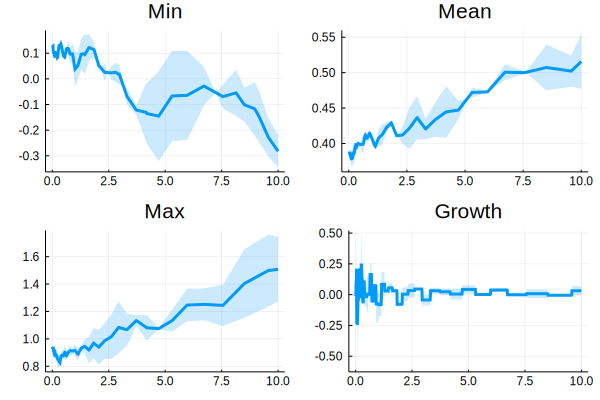

In [11]:
p = params(rate_index = rate_index, affect_index! = affect_index!, drift = drift, volatility = volatility)
sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)

p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Max")
p4 = plot(summ, idxs = [4], title = "Growth")
plot(p1, p2, p3, p4)

### (4) Variable Rates + Affects => Closures, Direct => DirectFW

In [12]:
# New boilerplate
function drift(du,u,p,t) # constant drift
      du .= p.μ
end
function volatility(du,u,p,t) # constant shock exposure
      du .= p.σ
end

function generate_jump_prob(p)
    # ========= CLOSURES ========= 
    affect_index!(integrator, index) = (integrator.u[index] = max(integrator.u[index], integrator.u[rand(1:integrator.p.N)]))
    function rate_index(u, p, t, index)
       u_max = maximum(u)
       u_min = minimum(u)
       return p.ρ_max* ((u[index] - u_max)^2 / (u_max - u_min))
    end
    x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, x_iv, (0.0, p.t[end]), p)
    # REPLACED CALLABLES IN THIS LINE WITH ANONYMOUS FUNCTIONS
    jumps = [VariableRateJump((u, p, t) -> rate_index(u, p, t, i), (integrator) -> affect_index!(integrator, i)) for i in 1:p.N];
    jump_prob = JumpProblem(sde_prob, Direct(), JumpSet((jumps),(),nothing,nothing))
    return jump_prob
end

function generate_ensemble_prob(p)
    prob = generate_jump_prob(p)
    function write_moments(sol, i)
        newsol = DiffEqBase.build_solution(sol.prob, sol.alg, sol.prob.p.t, sol.prob.p.moments)
        return newsol, false
    end
    function calculate_moments(u, t, integrator) 
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), maximum(u), g]
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    ensemble_prob = EnsembleProblem(prob, output_func = write_moments)    
    return ensemble_prob, cb
end

generate_ensemble_prob (generic function with 1 method)

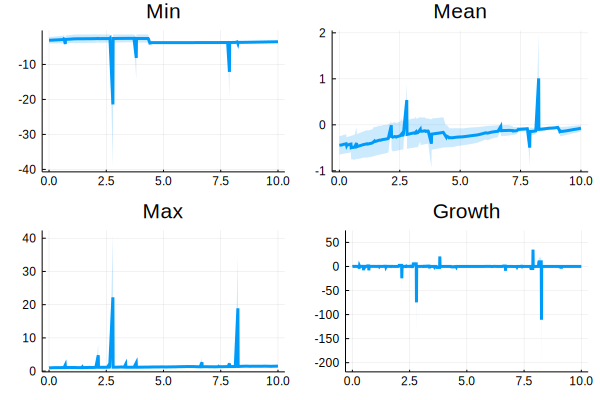

In [13]:
# main params bundle
params = @with_kw (
    μ = 0.01, # mean
    σ = 0.1, # drift
    N = 10, # num particles
    β = 0.2, # rate parameter
    t = 0.:0.01:10., # time steps to save
    moments = Array{Array{Float64, 1}, 1}(), # container for moments
    α = 2.0, # shape parameter for the initial condition distribution
    iv_dist = Exponential(1/α), # updates based on supplied α
    trajectories = 2, # number of members for ensemble methods 
    jump_algorithm = SRIW1(), # jump diffeq algorithm
    drift = drift, 
    volatility = volatility,
    ρ_max = 2.0)

p = params()
ensemble_prob, cb = generate_ensemble_prob(p)
sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)

p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Max")
p4 = plot(summ, idxs = [4], title = "Growth")

plot(p1, p2, p3, p4)